In [1]:
# Project Two
# 1. Sprawdzić i poprawić ewentualne błedy w danych [Done]
# 2. Dodać kolumnę - cena za metr kw. [Done] 
# 3. Przeprowadzić badanie z wykorzystaniem walidacji krzyżowej dla conajmniej 5 algorytmow
# 4. Zwizualizować wyniki eksperymentu
# 5. Przedstawić wnioski 
### UWAGA . Cena za metr kw. jest celem budowy modelu

In [2]:
# Data Loading

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

rawData = pd.read_csv("./Houses.csv", encoding='ISO-8859-2', index_col=0)

# Sanitize Integer Data
# Columns like floor, rooms, year and id
sanitizedData = rawData.copy()
sanitizedData['floor'] = sanitizedData['floor'].astype(int)
sanitizedData['id'] = sanitizedData['id'].astype(int)
sanitizedData['rooms'] = sanitizedData['rooms'].astype(int)
sanitizedData['year'] = sanitizedData['year'].astype(int)

# Denomination data, 1995. To verify, avg price is 4000 for 35m2 so prices here are not matching historical data
denominationYear = 1995
# denominationFactor = 10000
# sanitizedData.loc[sanitizedData['year'] < 1995, 'price'] = sanitizedData['price'] / denominationFactor
# sanitizedData.head()
sanitizedData = sanitizedData[sanitizedData['year'] >= 1995]

# Remove data about building status
def adjust_address(address):
    if 'Gotowy budynek' in address:
        return address.split()[0]  # Return only the first word if 'Gotowy budynek' is in the address
    else:
        return address 
        
sanitizedData['address'] = sanitizedData['address'].apply(adjust_address)

# Drop the ones with negative data in code fields
sanitizedData = sanitizedData[(sanitizedData['floor'] >= 0) & (sanitizedData['rooms'] >= 0) & (sanitizedData['price'] >= 0)]
sanitizedData

,address,city,floor,id,latitude,longitude,price,rooms,sq,year
0,Podgórze Zabłocie Stanisława Klimeckiego,Kraków,2,23918,50.049224,19.970379,749000.0,3,74.05,2021
1,Praga-Południe Grochowska,Warszawa,3,17828,52.249775,21.106886,240548.0,1,24.38,2021
4,Ochota,Warszawa,1,11770,52.212225,20.972630,996000.0,5,105.00,2020
5,Nowa Huta Czyżyny ul. Woniców,Kraków,2,26071,50.046943,19.997153,414600.0,1,34.55,2022
6,Podgórze Płaszów Koszykarska,Kraków,0,22569,50.049893,19.990603,750000.0,4,81.40,2021
...,...,...,...,...,...,...,...,...,...,...
23758,Nowe Miasto Rataje Wagrowska,Poznań,3,4516,52.378997,16.944244,294021.0,2,35.23,2022
23759,Stare Miasto Naramowice,Poznań,0,3976,52.449649,16.949408,543000.0,4,77.00,2020
23760,Włochy,Warszawa,4,10206,52.186109,20.948438,910000.0,3,71.00,2017
23761,Nowe Miasto Malta ul. Katowicka,Poznań,0,4952,52.397345,16.961939,430695.0,3,50.67,2022


In [2]:
# Remove rows that are not matching city long/lat
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from geopy.extra.rate_limiter import RateLimiter

## Sanitize city names
sanitizedData['city'] = sanitizedData['city'].str.lower()

## Initialize Nominatim API
geolocator = Nominatim(user_agent="MyApp")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

## Create a dictionary to store city coordinates
cityCoords = {}
for city in sanitizedData['city'].unique():
    location = geocode(city)
    if location:
        cityCoords[city] = (location.latitude, location.longitude)
        
def locationWithinTolerance(row, tolerance_km=10):
    city = row['city']
    propertyCoords = (row['latitude'], row['longitude'])
    
    if city in cityCoords:
        cityLatLon = cityCoords[city]
        distance = geodesic(cityLatLon, propertyCoords).kilometers
        return distance <= tolerance_km
    return False

sanitizedData = sanitizedData[sanitizedData.apply(locationWithinTolerance, axis=1)]
sanitizedData

,address,city,floor,id,latitude,longitude,price,rooms,sq,year
0,Podgórze Zabłocie Stanisława Klimeckiego,kraków,2,23918,50.049224,19.970379,749000.0,3,74.05,2021
1,Praga-Południe Grochowska,warszawa,3,17828,52.249775,21.106886,240548.0,1,24.38,2021
4,Ochota,warszawa,1,11770,52.212225,20.972630,996000.0,5,105.00,2020
5,Nowa Huta Czyżyny ul. Woniców,kraków,2,26071,50.046943,19.997153,414600.0,1,34.55,2022
6,Podgórze Płaszów Koszykarska,kraków,0,22569,50.049893,19.990603,750000.0,4,81.40,2021
...,...,...,...,...,...,...,...,...,...,...
23758,Nowe Miasto Rataje Wagrowska,poznań,3,4516,52.378997,16.944244,294021.0,2,35.23,2022
23759,Stare Miasto Naramowice,poznań,0,3976,52.449649,16.949408,543000.0,4,77.00,2020
23760,Włochy,warszawa,4,10206,52.186109,20.948438,910000.0,3,71.00,2017
23761,Nowe Miasto Malta ul. Katowicka,poznań,0,4952,52.397345,16.961939,430695.0,3,50.67,2022


In [3]:
# Calculate Price per square meter
sanitizedData['price_per_sqm'] = round(sanitizedData['price'] / sanitizedData['sq'], 2)
# Drop addresses as they are to unique
sanitizedData = sanitizedData.drop('address', axis=1)
sanitizedData

,city,floor,id,latitude,longitude,price,rooms,sq,year,price_per_sqm
0,Kraków,2,23918,50.049224,19.970379,749000.0,3,74.05,2021,10114.79
1,Warszawa,3,17828,52.249775,21.106886,240548.0,1,24.38,2021,9866.61
4,Warszawa,1,11770,52.212225,20.972630,996000.0,5,105.00,2020,9485.71
5,Kraków,2,26071,50.046943,19.997153,414600.0,1,34.55,2022,12000.00
6,Kraków,0,22569,50.049893,19.990603,750000.0,4,81.40,2021,9213.76
...,...,...,...,...,...,...,...,...,...,...
23758,Poznań,3,4516,52.378997,16.944244,294021.0,2,35.23,2022,8345.76
23759,Poznań,0,3976,52.449649,16.949408,543000.0,4,77.00,2020,7051.95
23760,Warszawa,4,10206,52.186109,20.948438,910000.0,3,71.00,2017,12816.90
23761,Poznań,0,4952,52.397345,16.961939,430695.0,3,50.67,2022,8500.00


In [13]:
# Calculate the 99th percentile for price and square meters
priceP999 = sanitizedData['price'].quantile(0.999)
sqP999 = sanitizedData['sq'].quantile(0.999)

sanitizedData = sanitizedData[(sanitizedData['price'] <= priceP999)]
sanitizedData = sanitizedData[(sanitizedData['sq'] <= sqP999)]
sanitizedData

,city,floor,id,latitude,longitude,price,rooms,sq,year,price_per_sqm
0,Kraków,2,23918,50.049224,19.970379,749000.0,3,74.05,2021,10114.79
1,Warszawa,3,17828,52.249775,21.106886,240548.0,1,24.38,2021,9866.61
4,Warszawa,1,11770,52.212225,20.972630,996000.0,5,105.00,2020,9485.71
5,Kraków,2,26071,50.046943,19.997153,414600.0,1,34.55,2022,12000.00
6,Kraków,0,22569,50.049893,19.990603,750000.0,4,81.40,2021,9213.76
...,...,...,...,...,...,...,...,...,...,...
23758,Poznań,3,4516,52.378997,16.944244,294021.0,2,35.23,2022,8345.76
23759,Poznań,0,3976,52.449649,16.949408,543000.0,4,77.00,2020,7051.95
23760,Warszawa,4,10206,52.186109,20.948438,910000.0,3,71.00,2017,12816.90
23761,Poznań,0,4952,52.397345,16.961939,430695.0,3,50.67,2022,8500.00


In [14]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Preprocessing
X = sanitizedData.drop('price_per_sqm', axis=1)
y = sanitizedData['price_per_sqm'] # target

# Handle categorical and numerical features differently
# text values
categoricalFeatures = ['city']
numericFeatures = X.drop(columns=categoricalFeatures).columns.tolist()

# Preprocessor setup
# StandardScaler - is used to normalize the features of your dataset so that they have a mean of zero and a standard deviation of one
# OneHotEncoder -  is used to normalize the features of your dataset so that they proper binary form for categorical values
# ex. creates columns based on city name with 0 & 1 values
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numericFeatures),
        ('cat', OneHotEncoder(), categoricalFeatures)
    ])

preprocessor

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['floor', 'id', 'latitude', 'longitude',
                                  'price', 'rooms', 'sq', 'year']),
                                ('cat', OneHotEncoder(), ['city'])])

In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, ShuffleSplit

# Algorithms
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# Create Models based on data & regression mechanism
# LinearRegression - model the relationship between one or more explanatory variables (features) and a continuous target variable by fitting a linear equation to observed data
# use case example: Predicting outcomes where the relationship between variables is expected to be linear.
# RandomForestRegressor - constructing a multitude of decision trees at training time and outputting the average prediction of the individual trees.
# use case example: high dimensional spaces and large numbers of training examples.
# SVR - [need to read more]
# use case example: Effective in high dimensional spaces.
# KNeighborsRegressor - KNN works by finding the k-nearest data points in the training dataset to the point that needs to be predicted and calculates the average
# use case example: Situations where the data naturally clusters well.
# DecisionTreeRegressor - Decision Trees split the data into smaller and smaller subsets based on different criteria, and decisions are made on the outcome variable at each leaf node of the tree.
# use case example: When there is a clear hierarchical decision process that splits the data well.
models = [
    ('Linear Regression', make_pipeline(preprocessor, LinearRegression())),
    ('Random Forest', make_pipeline(preprocessor, RandomForestRegressor(n_estimators=100))),
    ('SVR', make_pipeline(preprocessor, SVR())),
    ('KNN', make_pipeline(preprocessor, KNeighborsRegressor())),
    ('Decision Tree', make_pipeline(preprocessor, DecisionTreeRegressor()))
]

# split definition
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

results = {}
for name, model in models:
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    results[name] = scores
    
results

{'Linear Regression': array([-2590761.81578847, -2694463.58282681, -2604983.14051553,
        -6694335.13330714, -6486128.90793142, -2407304.18994095,
        -2461461.32380893, -2588633.80914539, -2503185.6403842 ,
        -2386333.03398775]),
 'Random Forest': array([  -92110.96494223,  -442465.28008363,  -137109.96487457,
        -3962342.51610745, -3873103.27311242,  -103380.74601364,
          -76261.72799738,  -111334.50062373,  -103644.75156935,
          -68444.40911489]),
 'SVR': array([-12750818.9783935 , -11684260.63172654, -13800476.88836026,
        -17125622.40728813, -17265785.59556742, -11912295.05115474,
        -12055407.08045126, -13538661.28558745, -12384726.92107733,
        -11418769.67235193]),
 'KNN': array([-1259920.35878755, -1468029.01984329, -1450318.18096865,
        -5747221.40753803, -5891858.09042316, -1234670.97736865,
        -1343989.10151766, -1222101.68949157, -1276863.8257892 ,
        -1272895.09446012]),
 'Decision Tree': array([ -222158.93634734

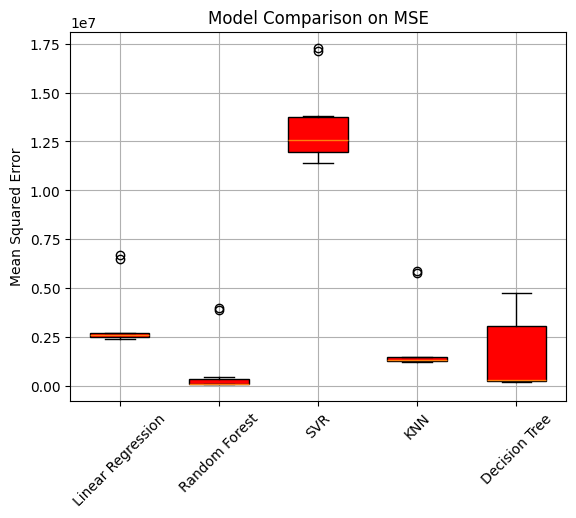

In [16]:
import matplotlib.pyplot as plt

# Visualizing the results
fig, ax = plt.subplots()
for name, scores in results.items():
    ax.boxplot(-scores, positions=[list(results.keys()).index(name)], widths=0.6, patch_artist=True, boxprops=dict(facecolor='r'))
ax.set_ylabel('Mean Squared Error')
ax.set_title('Model Comparison on MSE')
plt.xticks(ticks=list(range(len(results))), labels=results.keys(), rotation=45)
plt.grid()

plt.show()

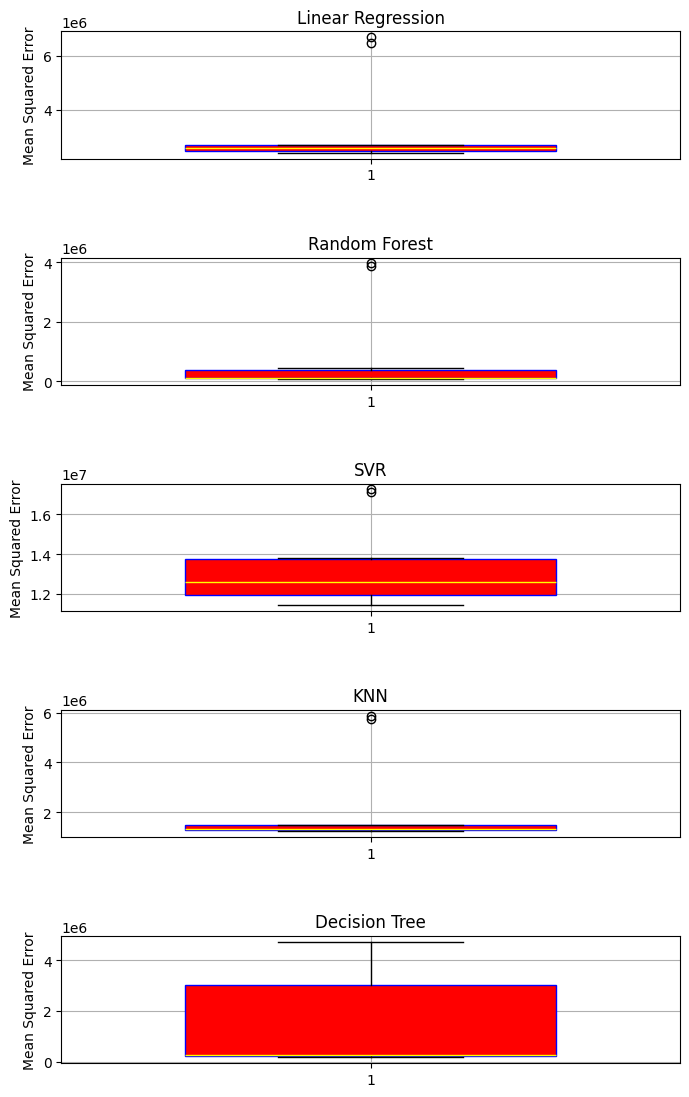

In [17]:
# Visualizing the results 2
fig, axes = plt.subplots(nrows=len(results), ncols=1, figsize=(8, 12))  # Adjust size as needed
fig.tight_layout(pad=5.0)  # Add space between plots

for ax, (name, scores) in zip(axes, results.items()):
    ax.boxplot(-scores, positions=[1], widths=0.6, patch_artist=True,
               boxprops=dict(facecolor='r', color='blue'),  # Box color settings
               medianprops=dict(color='yellow'))  # Median line color settings
    ax.set_title(name)
    ax.set_ylabel('Mean Squared Error')
    ax.grid()

plt.show()

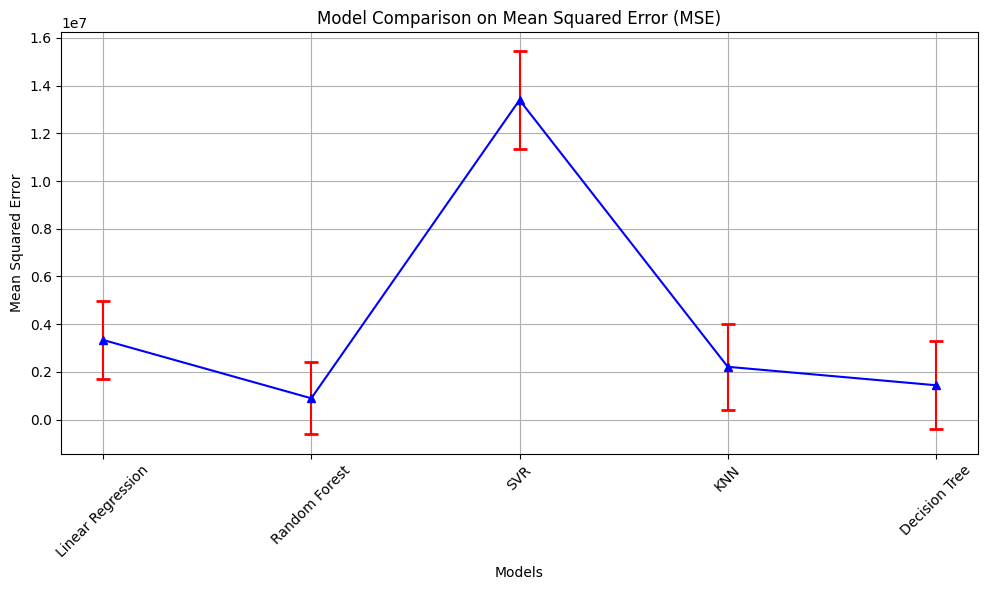

In [18]:
# Visualizing the results 3
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))
models = list(results.keys())
means = [-np.mean(scores) for scores in results.values()]  # Negate to get positive MSE
std_devs = [np.std(scores) for scores in results.values()]

ax.errorbar(models, means, yerr=std_devs, fmt='-^b', ecolor='r', capsize=5, capthick=2)

ax.set_title('Model Comparison on Mean Squared Error (MSE)')
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Models')
ax.set_xticks(np.arange(len(models)))
ax.set_xticklabels(models, rotation=45)

ax.grid(True)

plt.tight_layout()
plt.show()